In [41]:
import sys
sys.path.append("../")


import os
%matplotlib inline
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from patsy import dmatrices
from openpyxl import load_workbook

from linearmodels import PanelOLS


from library import print_statistics

In [42]:
def coef_with_stars(coef, pvalue):
    coef = round(coef, 2)
    if pvalue >.05:
        coef = str(coef)
    if pvalue <= .05:
        coef = str(coef) + '*'
    if pvalue <= .01:
        coef = coef + '*'
    if pvalue <= .001:
        coef = coef + '*'
    return(coef)
test = coef_with_stars(9.1568, .005)
test

'9.16**'

In [43]:
def format_se(se):
    if se < .005:
        se = '(0.00)'
    else:
        se = '(' + str(round(se, 2)) + ')'
    return se
test = format_se(.0053)
test

'(0.01)'

In [44]:
data_path = '/Users/kylieleblancKylie/domino/dofis/data/'
table_path = '/Users/kylieleblancKylie/domino/dofis/results/Who Needs Rules/'
data = pd.read_csv(os.path.join(data_path, 'clean', 'gdid.csv'),
                  sep=",", low_memory= False)
#load(data)
print(data[data.doi == True].district.nunique())
data = data[data.doi == True]

data.sample()

data['doi_year'] = np.where((data.doi_year == 2015), np.nan, data.doi_year) #drop first implementer (one district)


822


In [45]:
data.doi_year.value_counts()

2017.0    33831
2018.0     7586
2016.0     7422
2019.0     1633
Name: doi_year, dtype: int64

# Create trend and nonparametric variables

## Phase-in Effect - yearpost

In [46]:
data['yearpost'] = np.where(data.year > data.doi_year, data.year - data.doi_year, 0)
data[['year', 'doi_year', 'yearpost']].sample(10)

,year,doi_year,yearpost
1170,2012,2017.0,0.0
8805,2013,2018.0,0.0
5133,2012,2017.0,0.0
33803,2015,2017.0,0.0
66488,2019,2017.0,2.0
29368,2015,2016.0,0.0
39577,2016,2017.0,0.0
17210,2014,2017.0,0.0
14609,2013,2018.0,0.0
20182,2014,2017.0,0.0


In [47]:
data.yearpost.value_counts()

0.0    38694
1.0     6129
2.0     5190
3.0      938
Name: yearpost, dtype: int64

## Pretrends - yearpre

In [48]:
data['yearpre'] = np.where(data.year <= data.doi_year, data.year - data.doi_year, 0)
data[['year', 'doi_year', 'yearpost', 'yearpre']].sample(5)

,year,doi_year,yearpost,yearpre
68442,2019,2017.0,2.0,0.0
51335,2017,2017.0,0.0,0.0
23747,2014,2017.0,0.0,-3.0
2616,2012,2016.0,0.0,-4.0
58942,2018,2017.0,1.0,0.0


In [49]:
data.yearpre.value_counts()

 0.0    19082
-1.0     6329
-2.0     6293
-3.0     6275
-4.0     6263
-5.0     5356
-6.0     1152
-7.0      201
Name: yearpre, dtype: int64

## Non-parametric fixed effects for years pre and post - pre# and post#

In [50]:
data['pre5'] = np.where(data.yearpre <= -5, 1, 0)
data['pre4'] = np.where(data.yearpre == -4, 1, 0)
data['pre3'] = np.where(data.yearpre == -3, 1, 0)
data['pre2'] = np.where(data.yearpre == -2, 1, 0)
data['pre1'] = np.where(data.yearpre == -1, 1, 0)
data['pre0'] = np.where(data.yearpre == 0, 1, 0)
data['post1'] = np.where(data.yearpost == 1, 1, 0)
data['post2'] = np.where(data.yearpost == 2, 1, 0)
data['post3'] = np.where(data.yearpost == 3, 1, 0)


In [51]:
#convert year to datetime
df = data.reset_index()
df['year'] = pd.to_datetime(df['year'], format='%Y')
#add column year to index
df = data.set_index(['year', 'campus'])
#swap indexes
df.index = df.index.swaplevel(0,1)
df[['district', 'doi_year','treatpost']].sample(5)

,,district,doi_year,treatpost
campus,year,,,
65901101,2016,65901,2017.0,False
57914107,2013,57914,2017.0,False
220916007,2019,220916,2017.0,True
71902110,2017,71902,2016.0,True
101915045,2012,101915,2017.0,False


# Specifications

In [52]:
# Get table ready
file = table_path + 'tableX_gdid_and_event.xlsx'
wb = load_workbook(file)
ws = wb.active

## Simple GDID

In [53]:
mod = PanelOLS.from_formula('avescores ~ + 1 + treatpost + students_hisp + students_num + TimeEffects + EntityEffects', df)
res = mod.fit(cov_type='clustered', cluster_entity=True)
print(res)
ws.cell(row= 3, column= 2).value = coef_with_stars(res.params['treatpost[T.True]'], res.pvalues['treatpost[T.True]'])
ws.cell(row= 4, column= 2).value = format_se(res.std_errors['treatpost[T.True]'])

/Users/kylieleblancKylie/anaconda/envs/spacy/lib/python3.7/site-packages/linearmodels/utility.py:478: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:              avescores   R-squared:                        0.0044
Estimator:                   PanelOLS   R-squared (Between):              0.1126
No. Observations:               45633   R-squared (Within):              -0.0341
Date:                Thu, Dec 12 2019   R-squared (Overall):              0.0993
Time:                        17:14:50   Log-likelihood                   -4334.4
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      58.284
Entities:                        6088   P-value                           0.0000
Avg Obs:                       7.4956   Distribution:                 F(3,39535)
Min Obs:                       1.0000                                           
Max Obs:                       8.0000   F-statistic (robust):             15.562
                            

## GDID with Trends

In [54]:
mod = PanelOLS.from_formula('avescores ~ + 1 + treatpost + yearpost + yearpre + students_hisp + students_num + TimeEffects + EntityEffects', df)
res = mod.fit(cov_type='clustered', cluster_entity=True)
print(res)
#intercept = res.params['Intercept']
jump = res.params['treatpost[T.True]']
preslope = res.params['yearpre']
postslope = res.params['yearpost']
ws.cell(row= 6, column= 2).value = coef_with_stars(res.params['treatpost[T.True]'], res.pvalues['treatpost[T.True]'])
ws.cell(row= 7, column= 2).value = format_se(res.std_errors['treatpost[T.True]'])
ws.cell(row= 8, column= 2).value = coef_with_stars(res.params['yearpost'], res.pvalues['treatpost[T.True]'])
ws.cell(row= 9, column= 2).value = format_se(res.std_errors['yearpost'])
ws.cell(row= 10, column= 2).value = coef_with_stars(res.params['yearpre'], res.pvalues['treatpost[T.True]'])
ws.cell(row= 11, column= 2).value = format_se(res.std_errors['yearpre'])
wb.save(file)

/Users/kylieleblancKylie/anaconda/envs/spacy/lib/python3.7/site-packages/linearmodels/utility.py:478: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:              avescores   R-squared:                        0.0050
Estimator:                   PanelOLS   R-squared (Between):              0.1132
No. Observations:               45633   R-squared (Within):               0.0033
Date:                Thu, Dec 12 2019   R-squared (Overall):              0.1039
Time:                        17:15:00   Log-likelihood                   -4319.8
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      40.053
Entities:                        6088   P-value                           0.0000
Avg Obs:                       7.4956   Distribution:                 F(5,39533)
Min Obs:                       1.0000                                           
Max Obs:                       8.0000   F-statistic (robust):             10.534
                            

In [55]:
mod = PanelOLS.from_formula('avescores ~ + 1 + pre5 + pre4 + pre3 + pre2 + pre1 + post1 + post2 + post3 + students_hisp + students_num + TimeEffects + EntityEffects', df)
res = mod.fit(cov_type='clustered', cluster_entity=True)
print(res)
nonparametric = []
for coef in ['pre5', 'pre4', 'pre3', 'pre2', 'pre1', 'pre0', 'post1', 'post2', 'post3']:
    nonpar = 0
    if coef != 'pre0':
        nonpar = res.params[coef]
    nonparametric.append(nonpar)
print(nonparametric)
row = 3
for coef in ['post3', 'post2', 'post1', 'pre1', 'pre2', 'pre3', 'pre4', 'pre5']:
    ws.cell(row= row, column= 4).value = coef_with_stars(res.params[coef], res.pvalues[coef])
    row = row + 1
    ws.cell(row= row, column= 4).value = format_se(res.std_errors[coef])  
    row = row + 1
wb.save(file)

/Users/kylieleblancKylie/anaconda/envs/spacy/lib/python3.7/site-packages/linearmodels/utility.py:478: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:              avescores   R-squared:                        0.0052
Estimator:                   PanelOLS   R-squared (Between):              0.1121
No. Observations:               45633   R-squared (Within):              -0.0576
Date:                Thu, Dec 12 2019   R-squared (Overall):              0.0959
Time:                        17:15:02   Log-likelihood                   -4316.5
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      20.589
Entities:                        6088   P-value                           0.0000
Avg Obs:                       7.4956   Distribution:                F(10,39528)
Min Obs:                       1.0000                                           
Max Obs:                       8.0000   F-statistic (robust):             6.4783
                            

# Create graph (look up how to use predicted values)


In [56]:
years = [-5, -4, -3, -2, -1, 0, 1, 2, 3]
parametric = []
for year in years:
    par = 0
    if year < 0 :
        par = (year * preslope)
    if year > 0 :
        par = jump + (year * postslope)
    parametric.append(par)
parametric   

[-0.04265325316233112,
 -0.0341226025298649,
 -0.02559195189739867,
 -0.01706130126493245,
 -0.008530650632466224,
 0,
 -0.016017396202395773,
 -0.03885931372413267,
 -0.06170123124586958]

In [57]:
nonparametric

[-0.007794812902962666,
 -0.0014923384741299644,
 0.012707503021871932,
 0.007567100335969818,
 -0.0013726405270873337,
 0,
 -0.021304616882442333,
 -0.051815321744640035,
 -0.07860222609456029]

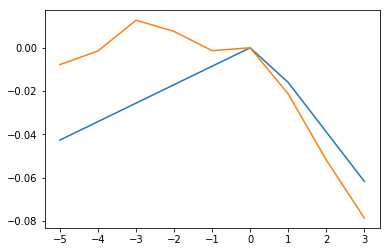

In [58]:
plt.plot(years, parametric)
plt.plot(years, nonparametric)

# Table

# Table by Subject

In [59]:
file = table_path + 'table3_gdid.xlsx'
row_n = 3
col_n = 2
wb = load_workbook(file)
ws = wb.active
outcomes = ['elem_math', 'elem_reading', 
            'middle_math', 'middle_reading', 'middle_science', 
            'biology', 'algebra', 'eng1']
for outcome in outcomes:
    model = outcome + ' ~ + 1 + treatpost + TimeEffects + EntityEffects'
    mod = PanelOLS.from_formula(model, df)
    res = mod.fit(cov_type='clustered', cluster_entity=True)
    p = res.pvalues['treatpost[T.True]']
    coef = res.params['treatpost[T.True]'].round(2)
    se = res.std_errors['treatpost[T.True]'].round(2)
    if p >= .05:
        coef = str(coef)
    if p < .05 and p > .01:
        coef = str(coef) + '*'
    if p < .01 and p > .001:
        coef = str(coef) + '**'
    if p < .001:
        coef = str(coef) + '***'
    ws.cell(row=row_n, column=col_n).value = coef
    row_n = row_n + 1
    ws.cell(row=row_n, column=col_n).value = '(' + str(se) + ')'
    row_n = row_n + 1
wb.save(file)

/Users/kylieleblancKylie/anaconda/envs/spacy/lib/python3.7/site-packages/linearmodels/utility.py:478: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


In [60]:
file = table_path + 'table3_gdid.xlsx'
row_n = 3
col_n = 3
wb = load_workbook(file)
ws = wb.active
outcomes = ['elem_math', 'elem_reading', 
            'middle_math', 'middle_reading', 'middle_science', 
            'biology', 'algebra', 'eng1']
for outcome in outcomes:
    model = outcome + ' ~ + 1 + treatpost + students_hisp + students_num + TimeEffects + EntityEffects'
    mod = PanelOLS.from_formula(model, df)
    res = mod.fit(cov_type='clustered', cluster_entity=True)
    print(res)
    p = res.pvalues['treatpost[T.True]']
    coef = res.params['treatpost[T.True]'].round(2)
    se = res.std_errors['treatpost[T.True]'].round(2)
    print(p)
    if p >= .05:
        coef = str(coef)
    if p < .05 and p > .01:
        coef = str(coef) + '*'
    if p < .01 and p > .001:
        coef = str(coef) + '**'
    if p < .001:
        coef = str(coef) + '***'
    ws.cell(row=row_n, column=col_n).value = coef
    row_n = row_n + 1
    ws.cell(row=row_n, column=col_n).value = '(' + str(se) + ')'
    row_n = row_n + 1
wb.save(file)

/Users/kylieleblancKylie/anaconda/envs/spacy/lib/python3.7/site-packages/linearmodels/utility.py:478: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:              elem_math   R-squared:                        0.0037
Estimator:                   PanelOLS   R-squared (Between):              0.0369
No. Observations:               27919   R-squared (Within):              -0.0292
Date:                Thu, Dec 12 2019   R-squared (Overall):              0.0322
Time:                        17:15:23   Log-likelihood                -1.084e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      30.066
Entities:                        3713   P-value                           0.0000
Avg Obs:                       7.5193   Distribution:                 F(3,24196)
Min Obs:                       1.0000                                           
Max Obs:                       8.0000   F-statistic (robust):             11.550
                            

                          PanelOLS Estimation Summary                           
Dep. Variable:         middle_science   R-squared:                        0.0042
Estimator:                   PanelOLS   R-squared (Between):              0.1321
No. Observations:               11297   R-squared (Within):              -0.0567
Date:                Thu, Dec 12 2019   R-squared (Overall):              0.1102
Time:                        17:15:24   Log-likelihood                   -5302.6
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      13.628
Entities:                        1568   P-value                           0.0000
Avg Obs:                       7.2047   Distribution:                  F(3,9719)
Min Obs:                       1.0000                                           
Max Obs:                       8.0000   F-statistic (robust):             6.1502
                            

# Heterogenous effects

In [61]:
### Generate variable for number of hispanic students in year before the district declares

In [62]:
data.teachers_turnover_ratio_d

3         8.1740
4        10.8636
5        10.8636
6        10.8636
7        10.8636
          ...   
69234     9.8000
69235     9.8000
69236     9.8000
69242    30.4000
69243    30.4000
Name: teachers_turnover_ratio_d, Length: 50951, dtype: float64

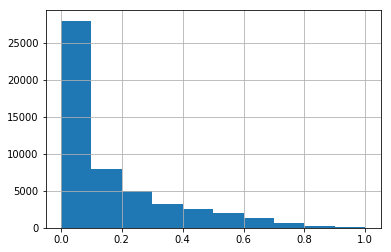

In [63]:
data.students_ell.hist()

In [65]:
data_pre = data.loc[data.yearpost == -1]
data_pre = data_pre.rename(columns = {'students_hisp': 'students_hisp_pre',
                                     'teachers_turnover_ratio_d': 'teacher_turnover_pre'})
data_pre['low_avescores_pre'] = np.where(data_pre.avescores < data_pre.avescores.quantile(.25),1, 0)
data_pre['high_avescores_pre'] = np.where(data_pre.avescores > data_pre.avescores.quantile(.75),1,0)
data_pre['low_avescores_pre'] = np.where(data_pre.students_ell < .1)
data_pre['high_avescores_pre'] = np.where(data_pre.students_ell > .1)

data_pre = data_pre[['campus','students_hisp_pre', 'teacher_turnover_pre', 'low_avescores_pre', 'high_avescores_pre']]
data_hte = data.merge(data_pre, on = 'campus', how = 'left')
data_hte['majority_hisp_pre'] = np.where(data_hte.students_hisp_pre > .6, 1, 0)
data_hte['high_turnover'] = np.where(data_hte.teacher_turnover_pre > 20, 1, 0)
data_hte

,Unnamed: 0,year,campus,campname,campischarter,district,distname,distischarter,rating_academic,rating_financial,...,pre0,post1,post2,post3,students_hisp_pre,teacher_turnover_pre,low_avescores_pre,high_avescores_pre,majority_hisp_pre,high_turnover
0,3,2012,109901001,ABBOTT SCHOOL,N,109901,ABBOTT ISD,N,NaN,NaN,...,0,0,0,0,NaN,NaN,NaN,NaN,0,0
1,4,2012,95901003,ABERNATHY DAEP,N,95901,ABERNATHY ISD,N,NaN,NaN,...,0,0,0,0,NaN,NaN,NaN,NaN,0,0
2,5,2012,95901101,ABERNATHY EL,N,95901,ABERNATHY ISD,N,NaN,NaN,...,0,0,0,0,NaN,NaN,NaN,NaN,0,0
3,6,2012,95901001,ABERNATHY H S,N,95901,ABERNATHY ISD,N,NaN,NaN,...,0,0,0,0,NaN,NaN,NaN,NaN,0,0
4,7,2012,95901041,ABERNATHY J H,N,95901,ABERNATHY ISD,N,NaN,NaN,...,0,0,0,0,NaN,NaN,NaN,NaN,0,0
5,8,2012,221901001,ABILENE H S,N,221901,ABILENE ISD,N,NaN,NaN,...,0,0,0,0,NaN,NaN,NaN,NaN,0,0
6,9,2012,221901010,ACADEMY FOR TECHNOLOGY ENGINEERING,N,221901,ABILENE ISD,N,NaN,NaN,...,0,0,0,0,NaN,NaN,NaN,NaN,0,0
7,10,2012,221901142,ACADIA ABILENE BEHAVIORAL HEALTH,N,221901,ABILENE ISD,N,NaN,NaN,...,0,0,0,0,NaN,NaN,NaN,NaN,0,0
8,11,2012,221901102,AUSTIN EL,N,221901,ABILENE ISD,N,NaN,NaN,...,0,0,0,0,NaN,NaN,NaN,NaN,0,0
9,12,2012,221901153,BASSETTI EL,N,221901,ABILENE ISD,N,NaN,NaN,...,0,0,0,0,NaN,NaN,NaN,NaN,0,0


In [66]:
data_pre = data.loc[data.year == 2016]
data_pre['rural_pre'] = np.where(data_pre.type_description == "RURAL", 1, 0)
data_pre['urban_pre'] = np.where(data_pre.type_description == "URBAN", 1, 0)
data_pre = data_pre[['campus','rural_pre', 'urban_pre']]
data_hte = data_hte.merge(data_pre, on = 'campus', how = 'left')
#df_hte[['students_hisp', 'students_hisp_pre', 'yearpost']].sample(5)

/Users/kylieleblancKylie/anaconda/envs/spacy/lib/python3.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/Users/kylieleblancKylie/anaconda/envs/spacy/lib/python3.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


In [67]:
#convert year to datetime
df_hte = data_hte.reset_index()
df_hte['year'] = pd.to_datetime(df_hte['year'], format='%Y')
#add column year to index
df_hte = data_hte.set_index(['year', 'campus'])
#swap indexes
df_hte.index = df_hte.index.swaplevel(0,1)
df_hte[['district', 'doi_year','treatpost',]].tail(20)

,,district,doi_year,treatpost
campus,year,,,
251901101,2019,251901,2017.0,True
251901104,2019,251901,2017.0,True
252901001,2019,252901,2017.0,True
252901002,2019,252901,2017.0,True
252901041,2019,252901,2017.0,True
252901101,2019,252901,2017.0,True
252901104,2019,252901,2017.0,True
252901105,2019,252901,2017.0,True
252902002,2019,252902,2017.0,True


# Majority Hispanic

In [68]:
df_hte['treatpost_hisp'] = df_hte.treatpost * df_hte.majority_hisp_pre
mod = PanelOLS.from_formula('avescores ~ + 1 + treatpost + treatpost_hisp + students_hisp + students_num + TimeEffects + EntityEffects', df_hte)
res = mod.fit(cov_type='clustered', cluster_entity=True)
print(res)

/Users/kylieleblancKylie/anaconda/envs/spacy/lib/python3.7/site-packages/linearmodels/utility.py:478: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


ValueError: exog does not have full column rank.

In [28]:
df_hte['treatpost_hisp'] = df_hte.treatpost * df_hte.majority_hisp_pre
df_hte['treatpost_hisp_rural'] = df_hte.treatpost_hisp * df_hte.rural_pre
mod = PanelOLS.from_formula('avescores ~ + 1 + treatpost + treatpost_hisp + treatpost_hisp_rural + TimeEffects + EntityEffects', df_hte)
res = mod.fit(cov_type='clustered', cluster_entity=True)
print(res)

/Users/kylieleblancKylie/anaconda/envs/spacy/lib/python3.7/site-packages/linearmodels/utility.py:478: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:              avescores   R-squared:                        0.0054
Estimator:                   PanelOLS   R-squared (Between):             -0.0102
No. Observations:               45033   R-squared (Within):              -0.0242
Date:                Mon, Oct 28 2019   R-squared (Overall):             -0.0119
Time:                        14:00:33   Log-likelihood                   -4403.5
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      70.884
Entities:                        5844   P-value                           0.0000
Avg Obs:                       7.7059   Distribution:                 F(3,39179)
Min Obs:                       1.0000                                           
Max Obs:                       8.0000   F-statistic (robust):             25.803
                            

In [27]:
df_hte[df_hte.majority_hisp_pre == 1][['district', 'type_description', 'majority_hisp_pre']]

,,district,type_description,majority_hisp_pre
campus,year,,,
95901003,2012,95901,RURAL,1
95901101,2012,95901,RURAL,1
221901006,2012,221901,OTHER CENTRAL CITY,1
221901152,2012,221901,OTHER CENTRAL CITY,1
221901125,2012,221901,OTHER CENTRAL CITY,1
180903001,2012,180903,RURAL,1
178901101,2012,178901,RURAL,1
178901001,2012,178901,RURAL,1
101902001,2012,101902,MAJOR SUBURBAN,1


# Rural

In [13]:
df_hte['treatpost_rural'] = df_hte.treatpost * df_hte.rural_pre
mod = PanelOLS.from_formula('avescores ~ + 1 + treatpost + treatpost_rural + rural_pre +  students_hisp + students_num  + TimeEffects + EntityEffects', df_hte)
res = mod.fit(cov_type='clustered', cluster_entity=True)
print(res)

/Users/kylieleblancKylie/anaconda/envs/spacy/lib/python3.7/site-packages/linearmodels/utility.py:478: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


AbsorbingEffectError: 
The model cannot be estimated. The included effects have fully absorbed
one or more of the variables. This occurs when one or more of the dependent
variable is perfectly explained using the effects included in the model.

The following variables or variable combinations have been fully absorbed
or have become perfectly collinear after effects are removed:

          Intercept, rural_pre

Set drop_absorbed=True to automatically drop absorbed variables.


# Performance

In [76]:
df_hte['treatpost_low'] = df_hte.treatpost * df_hte.low_avescores_pre
mod = PanelOLS.from_formula('avescores ~ + 1 + treatpost + treatpost_low + students_hisp + students_num  + TimeEffects + EntityEffects', df_hte)
res = mod.fit(cov_type='clustered', cluster_entity=True)
print(res)

/Users/kylieleblancKylie/anaconda/envs/spacy/lib/python3.7/site-packages/linearmodels/utility.py:478: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:              avescores   R-squared:                        0.0055
Estimator:                   PanelOLS   R-squared (Between):              0.1075
No. Observations:               44625   R-squared (Within):              -0.0371
Date:                Tue, Oct 15 2019   R-squared (Overall):              0.0922
Time:                        10:59:37   Log-likelihood                   -4385.5
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      53.286
Entities:                        5795   P-value                           0.0000
Avg Obs:                       7.7006   Distribution:                 F(4,38819)
Min Obs:                       1.0000                                           
Max Obs:                       8.0000   F-statistic (robust):             14.691
                            

In [77]:
df_hte['treatpost_high'] = df_hte.treatpost * df_hte.high_avescores_pre
mod = PanelOLS.from_formula('avescores ~ + 1 + treatpost + treatpost_high+ students_hisp + students_num  + TimeEffects + EntityEffects', df_hte)
res = mod.fit(cov_type='clustered', cluster_entity=True)
print(res)

/Users/kylieleblancKylie/anaconda/envs/spacy/lib/python3.7/site-packages/linearmodels/utility.py:478: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:              avescores   R-squared:                        0.0045
Estimator:                   PanelOLS   R-squared (Between):              0.1131
No. Observations:               44625   R-squared (Within):              -0.0372
Date:                Tue, Oct 15 2019   R-squared (Overall):              0.0979
Time:                        10:59:39   Log-likelihood                   -4406.3
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      44.207
Entities:                        5795   P-value                           0.0000
Avg Obs:                       7.7006   Distribution:                 F(4,38819)
Min Obs:                       1.0000                                           
Max Obs:                       8.0000   F-statistic (robust):             12.016
                            

# Teacher Turnover

In [78]:
df_hte['treatpost_turnover'] = df_hte.treatpost * df_hte.high_turnover
mod = PanelOLS.from_formula('avescores ~ + 1 + treatpost + treatpost_turnover + students_hisp + students_num + TimeEffects + EntityEffects', df_hte)
res = mod.fit(cov_type='clustered', cluster_entity=True)
print(res)

/Users/kylieleblancKylie/anaconda/envs/spacy/lib/python3.7/site-packages/linearmodels/utility.py:478: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:              avescores   R-squared:                        0.0049
Estimator:                   PanelOLS   R-squared (Between):              0.1116
No. Observations:               45633   R-squared (Within):              -0.0331
Date:                Tue, Oct 15 2019   R-squared (Overall):              0.0985
Time:                        11:00:01   Log-likelihood                   -4324.1
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      48.184
Entities:                        6088   P-value                           0.0000
Avg Obs:                       7.4956   Distribution:                 F(4,39534)
Min Obs:                       1.0000                                           
Max Obs:                       8.0000   F-statistic (robust):             13.505
                            